# Dog Vision

### This notebook builds an end-to-end multi-class image classifier using Tensorflow 2.0 and Tensorflow Hub

## 1. Problem

Identifying the breed of a dog when given an image of a dog

## 2. Data

Data supplied by Kaggle's Dog Breed Identification competition

## 3. Evaluation

- The evaluation is a file with prediction probabilities of each dog breed for each test image
- ~10,000 images in the training set (with labels)
- ~10,000 images in test set (no labels)

## 4. Features

120 classes (dog breeds)

In [208]:
import os
os.environ['TF_USE_LEGACY_KERAS'] = '1'

In [209]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [210]:
import tensorflow_hub as hub
import datetime, os

In [211]:
import zipfile
from IPython.display import Image
from io import BytesIO
from matplotlib.pyplot import imread

In [212]:
import tf_keras as keras

In [143]:
## Getting data ready, creating tensors

In [144]:
labels = pd.read_csv(('dog-breed-identification/labels.csv'))
#labels["breed"].value_counts().plot.bar(figsize=(20,10))

In [145]:
# Creating an array of training set filenames
filenames = ["dog-breed-identification/train/"+ fname +".jpg" for fname in labels['id']]
filenames[:10]

['dog-breed-identification/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'dog-breed-identification/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'dog-breed-identification/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'dog-breed-identification/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'dog-breed-identification/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'dog-breed-identification/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'dog-breed-identification/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'dog-breed-identification/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'dog-breed-identification/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

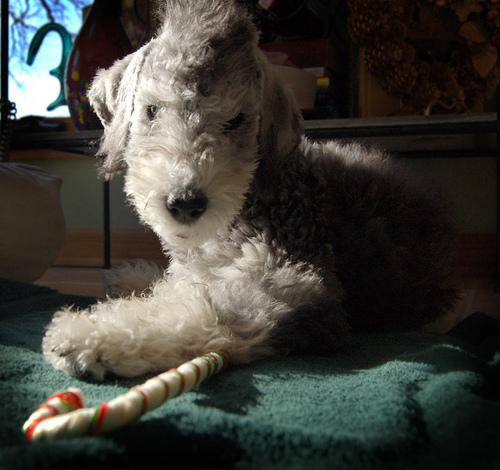

In [146]:
Image('dog-breed-identification/train/00290d3e1fdd27226ba27a8ce248ce85.jpg')

In [147]:
labels = labels['breed']

In [417]:
labels = np.array(labels)
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [418]:
unique_breeds = np.unique(labels)

In [419]:
# Turn every label into a boolean
boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[2].astype(int)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [420]:
# Creating Training and Validation Sets
from sklearn.model_selection import train_test_split
X = filenames
y = boolean_labels
NUM_IMAGES = 1000

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES], y[:NUM_IMAGES], test_size=0.2, random_state=42)

len(X_train), len(X_val), len(y_train), len(y_val)




(800, 200, 800, 200)

### Preprocessing Images into Tensors
Preprocessing Function Steps:
- Take an image filepath as input
- Read file with Tensorflow and save to a variable
- Turn image into a Tensor
- Resize image to shape of (244, 244)
- Return modified image


In [421]:
image = imread(filenames[42])
image.shape, image.max(), image.min()

((257, 350, 3), 255, 0)

In [449]:
tf.constant(image).shape

TensorShape([257, 350, 3])

## Converting image data into tuples of Tensors (image, label)

In [450]:
IMG_SIZE = 224
def process_image(filepath, img_size = IMG_SIZE):
    """
    Preprocesses an image into a Tensor
    """
    image = tf.io.read_file(filepath) # read in file
    image = tf.image.decode_jpeg(image, channels=3)  # convert to tensor
    image = tf.image.convert_image_dtype(image, tf.float32)  # normalize color channels to 0-1 values
    image = tf.image.resize(image, size= [IMG_SIZE, IMG_SIZE]) # convert to square dimensions
    return image
    

In [451]:
# Function to return a tuple (image, label)
def get_image_label(filepath, label): # filepath = X, label = y
    """
    Take an image file path and associated label, 
    returns processed image and associated label as a tuple
    """
    image = process_image(filepath)
    return image, label

In [452]:
# Demo of the above
(process_image(X[42]), tf.constant(y[42]))

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117759],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

## Batchify

In [453]:
BATCH_SIZE = 32

def create_data_batches(X, y=None, batch_size = BATCH_SIZE, valid_data = False, test_data = False):
    """
    Creates batches of data out of image(X), and label(y) pairs, 
    and shuffles the data if it's training data but doesn't shuffle if it's validation data.
    Also accepts test data as input (no labels)
    """
    if test_data: # sans labels
        print("Creating test data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X))),
        data_batch = data.map(process_image).batch(BATCH_SIZE)
        
        return data_batch
    
    elif valid_data: # If valid dataset, no shuffling necessary
        print("Creating validation data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
        
        return data_batch

    else:
        print("Creating training data batches...")
        # Turn filepaths and labels into tensors
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))

        # Shuffling pathnames and labels before mapping for improved time complexity
        data = data.shuffle(buffer_size = len(X))

        # Create (image, label) tuples. Also filepath --> preprocessed image
        data = data.map(get_image_label) 

        # Turn training data into batches
        data_batch = data.batch(BATCH_SIZE)
    return data_batch
        

In [454]:
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data = True)

Creating training data batches...
Creating validation data batches...


In [455]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [456]:
# Function for viewing images in a batch

def show_25_images(images, labels):
    plt.figure(figsize=(10,10))
    for i in range(25):
        ax=plt.subplot(5, 5, i+1)
        
        # display an image
        plt.imshow(images[i])
        
        #add image label as title
        plt.title(unique_breeds[labels[i].argmax()])
        plt.axis('off')

In [457]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [458]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [637]:
train_images, train_labels = next(train_data.as_numpy_iterator())

array([[False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]])

In [460]:
#show_25_images(train_images, train_labels)


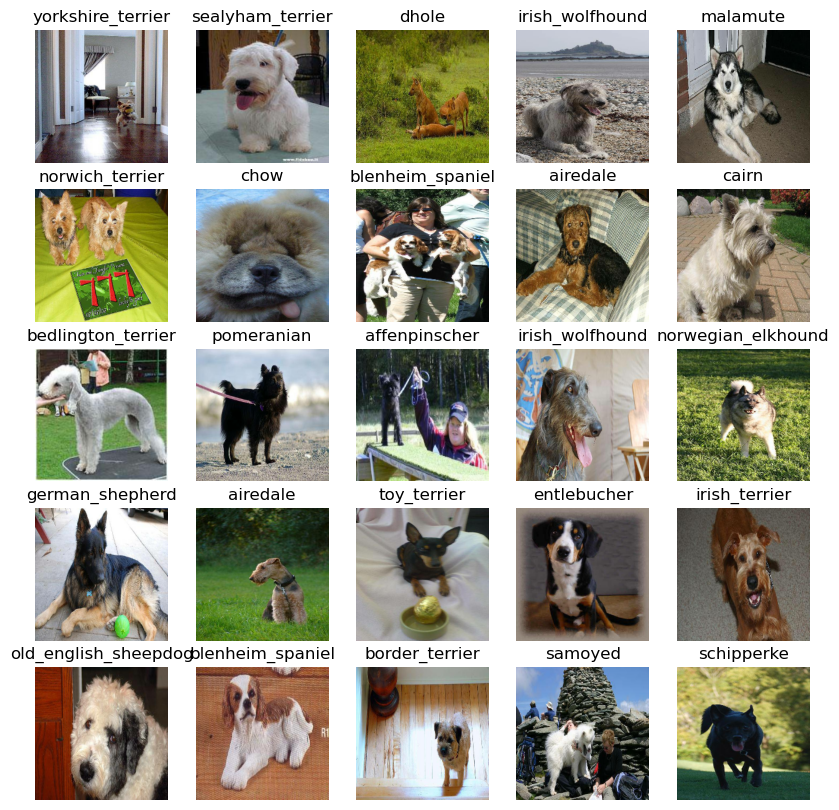

In [461]:
val_images, val_labels = next(train_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building the model

Define:
- input shape
- output shape
- model URL

In [462]:
# set up input shape
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# set up output shape
OUTPUT_SHAPE = len(unique_breeds)

# set up model URL from Tensorflow Hub
MODEL_URL = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-classification/2"

### Function for creating Keras model which:
 - Takes input, output, and model as parametersD
 - Defines layers sequentially
 - Compiles model
 - Builds model
 - Returns model



In [463]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
    # MODEL LAYERS:
    model = tf.keras.Sequential([
        # Layer 1: input layer
        hub.KerasLayer(MODEL_URL),
        # Layer 2: output layer
        tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")
    ])

    # COMPILE MODEL:
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(), 
        optimizer = tf.keras.optimizers.Adam(), 
        metrics = ["accuracy"]
    )

    # BUILD MODEL
    model.build(INPUT_SHAPE)

    return model 

In [464]:
model = create_model()
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 1001)              3540265   
                                                                 
 dense_6 (Dense)             (None, 120)               120240    
                                                                 
Total params: 3660505 (13.96 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 3540265 (13.51 MB)
_________________________________________________________________


## CALLBACKS
### via Tensorboard
Helper functions that allow a model to save and check its progress during training, or stop training early if necessary

### Setup
1) Load tensorboard extension
2) Create tensorboard callback which is able to save logs to a directory and pass it to our model's 'fit()' function
3) Visualize our model's training logs with the %tensorboard magic function post-training

In [465]:
%reload_ext tensorboard

In [466]:
def create_tensorboard_callback():
    logdir = os.path.join('Dog Vision/logs', 
            datetime.datetime.now().strftime("%y%m%d-%H%M%S"))
    return tf.keras.callbacks.TensorBoard(logdir)

In [467]:
# Early Stopping Callback to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

## Training a model on 1000 image subset

1) create a model using create_model
2) set up tensorboard callback using create_tensorboard_callback
3) call fit() function on the model, passing the training and validation data, callbacks, and num_epochs
4) return the model

In [468]:
NUM_EPOCHS = 100

def train_model():
    """
    Takes a given model and returns the trained version
    """
    # Create model
    model = create_model()

    # Create new tensorboard session every time a model is trained
    tensorboard = create_tensorboard_callback()

    # Fit model to the training data
    model.fit(x=train_data,  
              epochs=NUM_EPOCHS, 
              validation_data = val_data, 
              validation_freq = 1, 
              callbacks = ([tensorboard, early_stopping]))
    return model

In [469]:
model = train_model()

Epoch 1/100
25/25 [==============================] - 22s 707ms/step - loss: 4.3844 - accuracy: 0.1200 - val_loss: 3.1866 - val_accuracy: 0.3150
Epoch 2/100
25/25 [==============================] - 17s 681ms/step - loss: 1.4738 - accuracy: 0.7100 - val_loss: 1.9932 - val_accuracy: 0.5450
Epoch 3/100
25/25 [==============================] - 17s 686ms/step - loss: 0.4900 - accuracy: 0.9488 - val_loss: 1.5377 - val_accuracy: 0.6450
Epoch 4/100
25/25 [==============================] - 18s 705ms/step - loss: 0.2237 - accuracy: 0.9912 - val_loss: 1.3876 - val_accuracy: 0.6850
Epoch 5/100
25/25 [==============================] - 17s 679ms/step - loss: 0.1278 - accuracy: 0.9987 - val_loss: 1.3293 - val_accuracy: 0.6800
Epoch 6/100
25/25 [==============================] - 17s 688ms/step - loss: 0.0885 - accuracy: 0.9987 - val_loss: 1.2959 - val_accuracy: 0.7050
Epoch 7/100
25/25 [==============================] - 17s 678ms/step - loss: 0.0669 - accuracy: 1.0000 - val_loss: 1.2740 - val_accuracy:

### Initial model overfitting on the training data set

### The Tensorboard magic function will access the logs directory created by the callback and visualize its contents

In [470]:
%tensorboard --logdir Dog\ Vision/logs

Reusing TensorBoard on port 6006 (pid 45642), started 6:42:06 ago. (Use '!kill 45642' to kill it.)

## Making and evaluating predictions using a trained model

In [471]:
predictions = model.predict(val_data, verbose=1 )

7/7 [==============================] - 4s 452ms/step


In [472]:
predictions

array([[7.88818346e-04, 1.25522166e-03, 5.19148343e-05, ...,
        4.00680961e-04, 7.23928795e-04, 1.86176063e-03],
       [2.67779047e-04, 4.17762465e-04, 3.86426109e-03, ...,
        5.60747576e-04, 2.53356498e-04, 5.77575929e-06],
       [7.96429777e-06, 2.62812100e-04, 1.65417600e-06, ...,
        2.47491174e-04, 1.95635967e-05, 8.68802716e-04],
       ...,
       [2.27456148e-05, 1.37219133e-04, 3.61037273e-05, ...,
        2.40424488e-05, 4.97390647e-05, 2.36525884e-04],
       [5.52221492e-04, 9.96975505e-05, 9.74303257e-05, ...,
        2.22843664e-05, 1.06613705e-04, 1.54373376e-02],
       [1.05172563e-04, 5.90788914e-05, 9.97143215e-04, ...,
        3.72895435e-03, 3.26133030e-03, 9.62836028e-04]], dtype=float32)

In [473]:
predictions.shape

(200, 120)

In [474]:
print(predictions[0])

[7.8881835e-04 1.2552217e-03 5.1914834e-05 3.4323477e-04 3.6306118e-03
 1.4997958e-04 2.9414248e-02 6.2434664e-03 1.6233106e-03 3.1057408e-04
 4.9346942e-04 2.0942988e-04 1.1089417e-03 1.3431247e-04 1.4883974e-04
 1.4673888e-03 2.6114851e-05 5.2993599e-02 7.4006013e-05 2.2473208e-04
 8.1672138e-03 8.8160962e-04 4.9744409e-05 2.6295825e-03 6.6464609e-06
 2.0392465e-04 9.6361302e-02 7.3425967e-05 3.6786898e-04 7.5121486e-04
 2.1320237e-03 1.1329942e-02 1.0024207e-03 1.4681999e-04 2.2281665e-05
 6.0628574e-02 1.0252430e-04 4.8750316e-04 1.6449468e-04 6.3467986e-04
 4.6141108e-04 4.6105364e-05 1.7772762e-05 1.8218582e-03 1.2790239e-04
 2.0722608e-04 3.4253615e-05 1.2709335e-02 1.7491565e-03 2.1095989e-04
 5.5615070e-05 8.7947323e-04 1.8430833e-03 4.3612570e-03 6.6817047e-05
 6.4521686e-05 3.8081393e-04 2.4241677e-03 2.6351158e-03 6.6891392e-03
 5.1232120e-03 5.3179978e-05 4.5703535e-04 5.7019632e-05 2.9999233e-04
 4.0955901e-02 3.7533548e-05 1.5453043e-05 4.8358808e-03 9.8314224e-05
 3.135

In [496]:
# Extracting predicted class label from array of prediction probabilities 

index = 0
print(predictions[index])
print(f"Max value (probability of prediction): {np.max(predictions[index])}")
print(f"Sum: {np.sum(predictions[index])}")
print(f"Max Index: {np.argmax(predictions[index])}")
print(f"Predicted Label: {unique_breeds[np.argmax(predictions[index])]}")

[7.8881835e-04 1.2552217e-03 5.1914834e-05 3.4323477e-04 3.6306118e-03
 1.4997958e-04 2.9414248e-02 6.2434664e-03 1.6233106e-03 3.1057408e-04
 4.9346942e-04 2.0942988e-04 1.1089417e-03 1.3431247e-04 1.4883974e-04
 1.4673888e-03 2.6114851e-05 5.2993599e-02 7.4006013e-05 2.2473208e-04
 8.1672138e-03 8.8160962e-04 4.9744409e-05 2.6295825e-03 6.6464609e-06
 2.0392465e-04 9.6361302e-02 7.3425967e-05 3.6786898e-04 7.5121486e-04
 2.1320237e-03 1.1329942e-02 1.0024207e-03 1.4681999e-04 2.2281665e-05
 6.0628574e-02 1.0252430e-04 4.8750316e-04 1.6449468e-04 6.3467986e-04
 4.6141108e-04 4.6105364e-05 1.7772762e-05 1.8218582e-03 1.2790239e-04
 2.0722608e-04 3.4253615e-05 1.2709335e-02 1.7491565e-03 2.1095989e-04
 5.5615070e-05 8.7947323e-04 1.8430833e-03 4.3612570e-03 6.6817047e-05
 6.4521686e-05 3.8081393e-04 2.4241677e-03 2.6351158e-03 6.6891392e-03
 5.1232120e-03 5.3179978e-05 4.5703535e-04 5.7019632e-05 2.9999233e-04
 4.0955901e-02 3.7533548e-05 1.5453043e-05 4.8358808e-03 9.8314224e-05
 3.135

In [507]:
def visualize_preds(predictions):
    for i in range(len(predictions)):
        print(f"Predicted Label: {unique_breeds[np.argmax(predictions[i])]}")
    return

def get_pred_labels(prediction_probabilities):
    return unique_breeds[np.argmax(prediction_probabilities)]
 
#predicted_labels = visualize_preds(predictions)

## Unbatching Data

In [598]:
pred_label = get_pred_labels(predictions[0])


'lhasa'

In [532]:
def unbatchify(data):
    images_ = []
    labels_ = []
    
    for image, label in val_data.unbatch().as_numpy_iterator():
        images_.append(image)
        labels_.append(unique_breeds[np.argmax(label)])
    
    return images_, labels_

In [533]:
val_images, val_labels = unbatchify(val_data)


2024-08-19 19:16:16.062937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Creating a function which:
1) Takes an array of prediction probabilities, an array of truth labels, an array of images, and an integer
2) Converts the prediction probabilities to a predicted label
3) Plots the predicted label, its predicted probability, the truth label, and the target image on a single plot

In [534]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [543]:
def plot_pred(prediction_probabilities, labels, images, n=1):
    pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

    #get pred label
    pred_label = get_pred_labels(pred_prob)

    # Plot image and remove ticks
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    # Color formatting to denote correct or incorrect predictions
    if pred_label == true_label:
        color = 'green'
    else:
        color = 'red'
    
    # changing plot title to be predicted, probability of prediction with truth label
    plt.title("{} {:2.0f}% {}".format(pred_label, 
                                       np.max(pred_prob)*100, 
                                       true_label), 
                                         color = color)
    
    

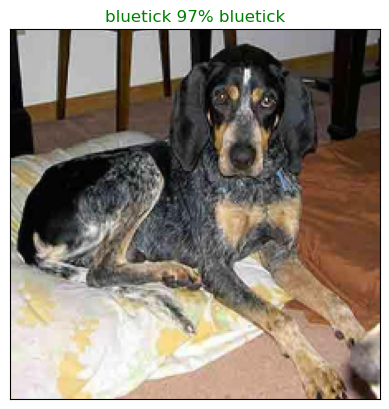

In [550]:
plot_pred(prediction_probabilities = predictions, labels = val_labels, images = val_images, n=197)

### Function to view top 10 predictions will:
1) Take as input an array of prediction probabilities, a groundtruth array, and an integer
2) Find the prediction using 'the get_pred_label()' function
3) Find the top 10 prediction indexes, values, labels
4) Plot the top predictions and color the truth label green

In [589]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
    pred_prob, true_label = prediction_probabilities[n], labels[n]

    # get predicted label
    pred_label = get_pred_labels(pred_prob)

    # Top 10 prediction confidence indexes
    top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
    # Top 10 prediction values
    top_10_pred_values = pred_prob[top_10_pred_indexes]

    # Prediction Labels
    top_10_pred_labels = unique_breeds[top_10_pred_indexes]

    # Setup Plot
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
    top_10_pred_values, 
    color='grey')

    plt.xticks(np.arange(len(top_10_pred_labels)), 
               labels = top_10_pred_labels, 
               rotation = 'vertical')
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels == true_label)].set_color('green')
    else:
        pass
    plt.yticks

In [3]:
predictions[0].argsort()[-10:]

NameError: name 'predictions' is not defined

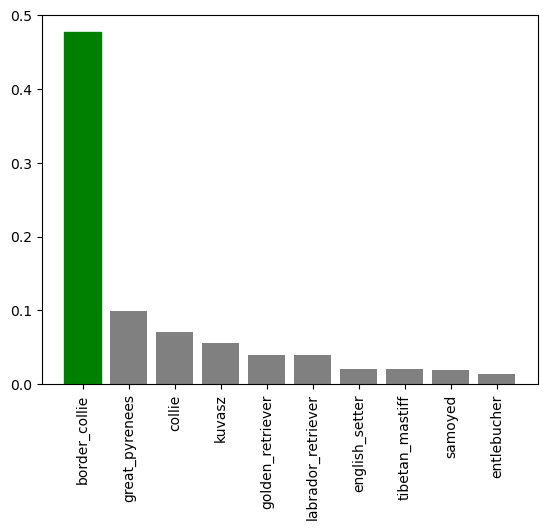

In [591]:
plot_pred_conf(prediction_probabilities = predictions, labels = val_labels, n=11)

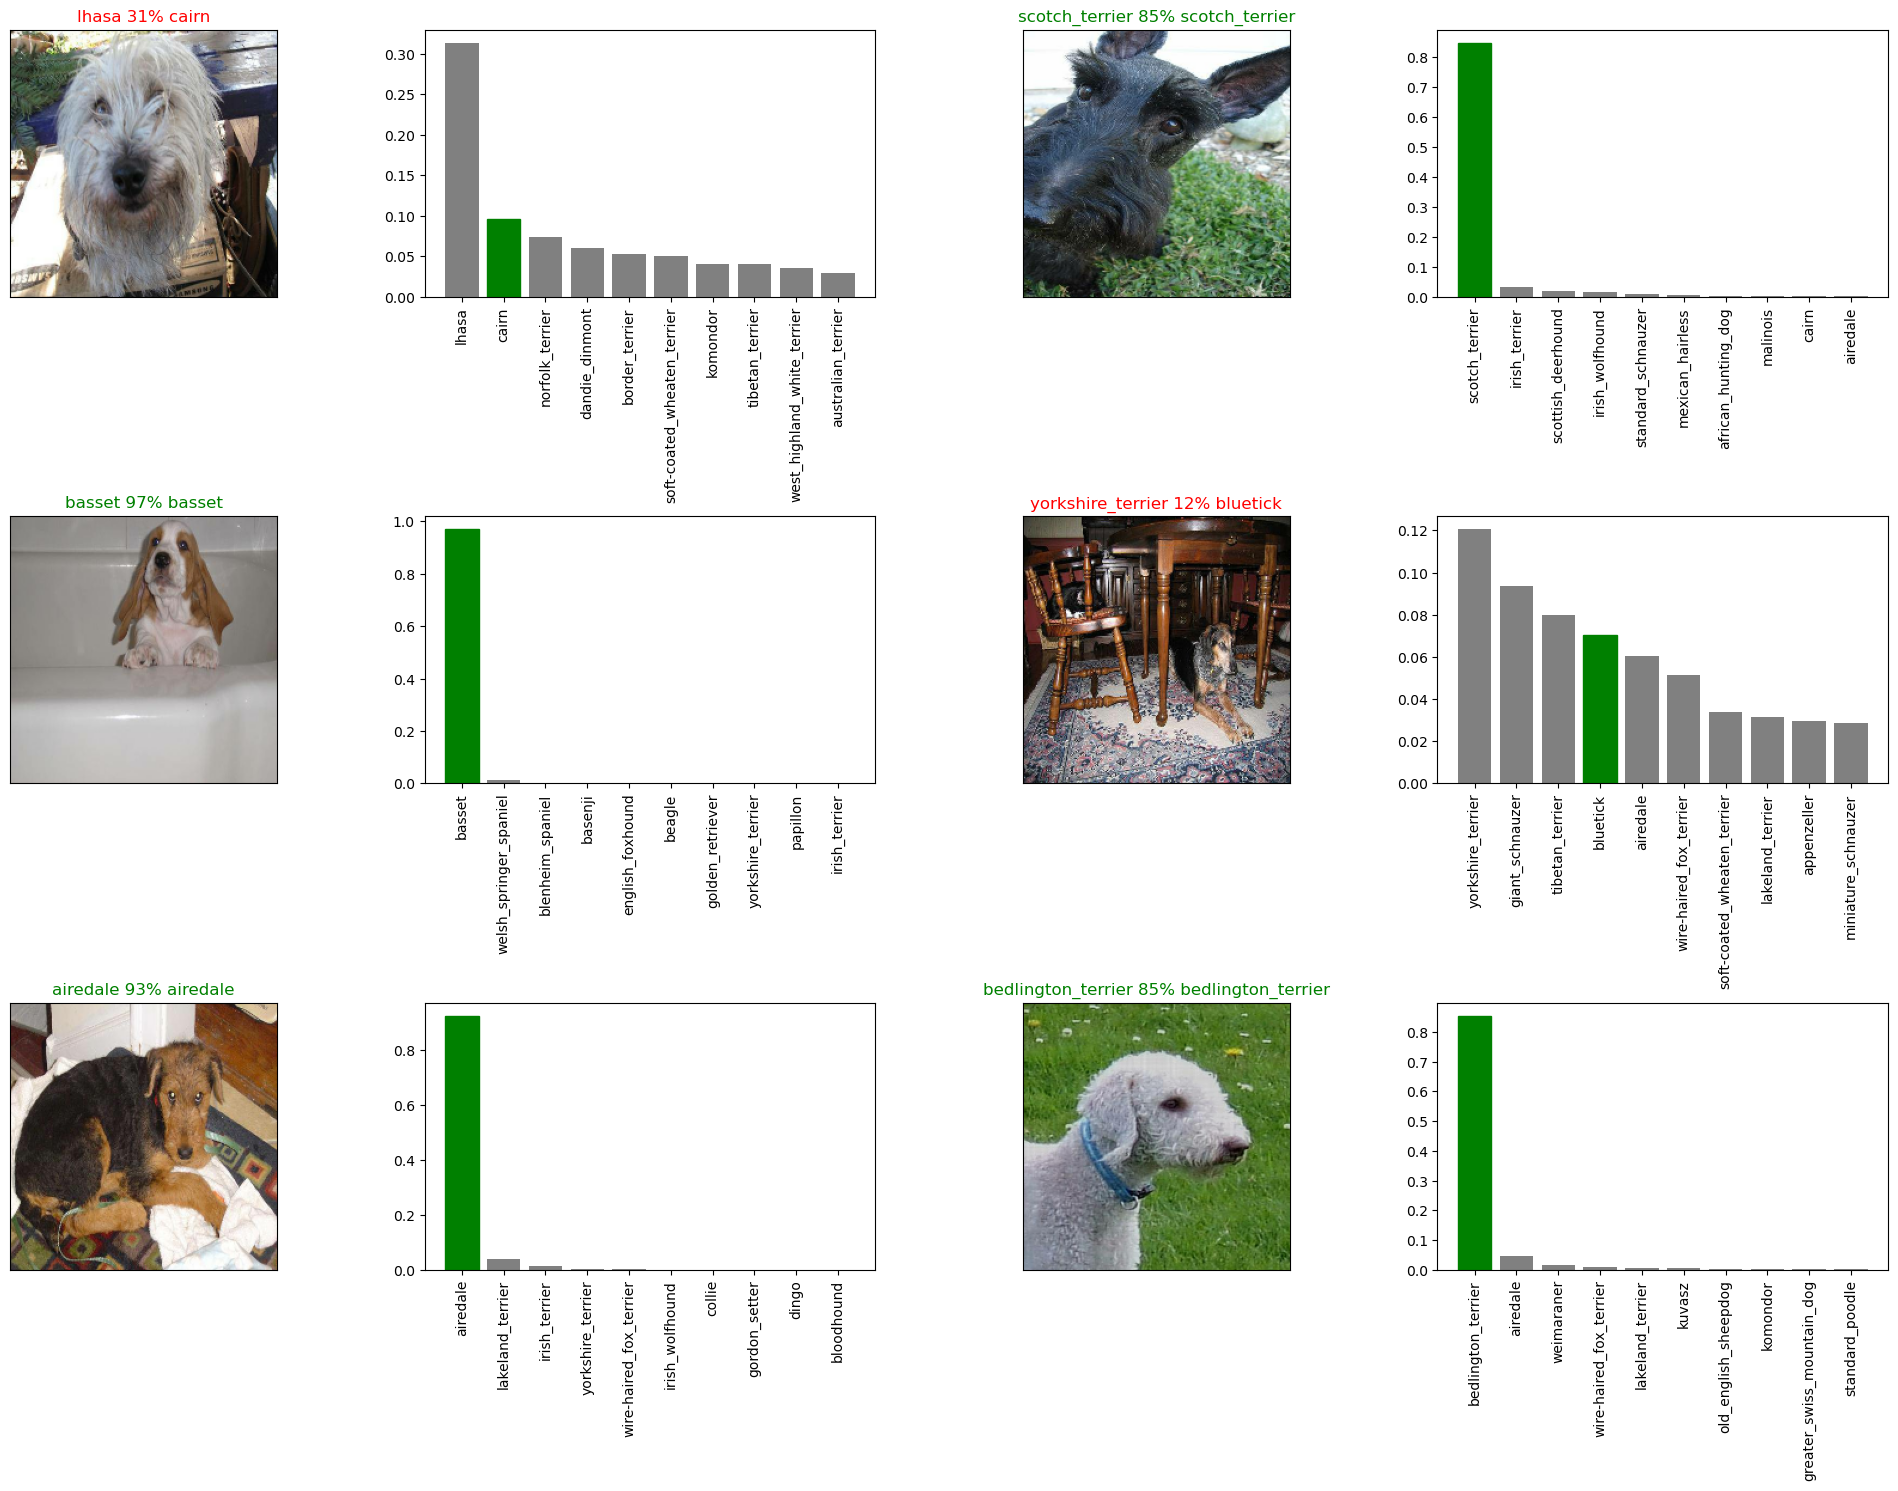

In [592]:
i_multiplier = 0
num_rows = 3
num_cols = 2
num_images = num_rows*num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_pred(prediction_probabilities = predictions, 
                labels = val_labels, 
                images = val_images, 
                n = i+i_multiplier)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_pred_conf(prediction_probabilities = predictions, 
                    labels = val_labels, 
                    n = i+i_multiplier)
plt.tight_layout(h_pad = 1.0)
plt.show()

In [595]:
from sklearn.metrics import confusion_matrix

In [607]:
def save_model(model, suffix=None):
    # create a model directory with the current date/time
    modeldir = os.path.join('Dog Vision'), datetime.datetime.now().strftime("%Y%m%d - %H%M%s")
    model_path = modeldir + '_' + suffix + '_' + ".h5"
    print(f"Saving model to: {model_path} ...")
    model.save(model_path)
    return model_path

def load_model(model_path):
    print(f"Loading saved model from: {model_path}...")
    model = tf.keras.models.load(model_path, custom_objects = {"KerasLayer":hub.KerasLayer})

In [616]:
y_preds = model.predict(val_data)

7/7 [==============================] - 4s 488ms/step


In [696]:
y_true = tf.constant(y[:200])
y_true
#list(y_true)

<tf.Tensor: shape=(200, 120), dtype=bool, numpy=
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])>